In [ ]:
!pip install pyspark==2.4.5

In [ ]:
!pip install tensorflow==2.2.0rc0

In [1]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [2]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#from tf.keras.losses.BinaryCrossentropy
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline
import tensorflow as tf
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


In [ ]:
!pip install geopandas

In [3]:
import geopandas

### Dataset: Kenya polulation census 2009  in geojson format

In [4]:
url = "https://opendata.arcgis.com/datasets/4b8b2da624ba4cdf9cd38b5f359eecf3_0.geojson "
df = geopandas.read_file(url)

### Explore dataset

In [5]:
df.head()

,County,Male,Female,Total,No_of_HouseHolds,Area_in_Square_Km,Gender_Index,Household_Density,Population_Density,Location_1,OBJECTID,geometry
0,BARINGO,279081,276480,555561,110649,11015.34,1.0,50.44,50.44,"(0.66898646421, 35.9461427526)",0,None
1,BOMET,359727,364459,724186,142361,2471.30,1.0,293.04,293.04,"(-0.828313516948, 35.2718580721)",1,None
2,BUNGOMA,671548,703515,1375063,270824,3032.15,1.0,453.49,453.49,"(0.751266866555, 34.6400640229)",2,None
3,BUSIA,356122,387824,743946,154225,1695.03,1.1,438.90,438.90,"(0.414922272151, 34.2119561811)",3,None
4,ELGEYO MARAKWET,183738,186260,369998,77555,3029.78,1.0,122.12,122.12,"(-0.599583761487, 37.6238616686)",4,None


In [6]:
df.shape

(47, 12)

### Determine correlation 

In [7]:
df.corr(method ='pearson')

,Male,Female,Total,No_of_HouseHolds,Area_in_Square_Km,Gender_Index,Household_Density,Population_Density,OBJECTID
Male,1.000000,0.992750,0.998200,0.957182,-0.222593,0.130123,0.597814,0.597813,-0.069373
Female,0.992750,1.000000,0.998171,0.954424,-0.279230,0.232896,0.570666,0.570665,-0.096232
Total,0.998200,0.998171,1.000000,0.957546,-0.251254,0.181632,0.585356,0.585355,-0.082899
No_of_HouseHolds,0.957182,0.954424,0.957546,1.000000,-0.316664,0.183406,0.686733,0.686732,-0.047370
Area_in_Square_Km,-0.222593,-0.279230,-0.251254,-0.316664,1.000000,-0.557413,-0.281390,-0.281391,0.180302
Gender_Index,0.130123,0.232896,0.181632,0.183406,-0.557413,1.000000,-0.014089,-0.014089,-0.122534
Household_Density,0.597814,0.570666,0.585356,0.686733,-0.281390,-0.014089,1.000000,1.000000,0.062260
Population_Density,0.597813,0.570665,0.585355,0.686732,-0.281391,-0.014089,1.000000,1.000000,0.062260
OBJECTID,-0.069373,-0.096232,-0.082899,-0.047370,0.180302,-0.122534,0.062260,0.062260,1.000000


### Check Distrubution of the population

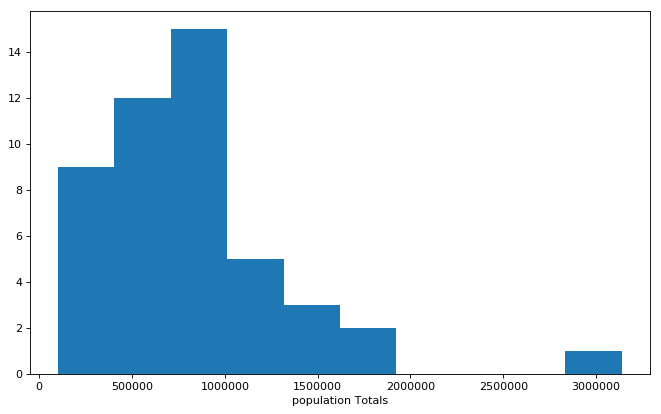

In [8]:
x= df['Total']
fig, ax = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax.hist(x, bins=10)
plt.xlabel('population Totals')
plt.show()

### Data cleaning: null columns, duplcate columns

In [9]:
df1=df.drop(['geometry'], axis=1)

### create spark session and convert pandas data frame into spark dataframe

In [10]:
spark = SparkSession.builder.appName("kenyaPop").master("local[*]").getOrCreate()

kenya_df = spark.createDataFrame(df1)
kenya_df.createOrReplaceTempView('kenya_df')


### display first five rows

In [11]:
kenya_df.show(5)

+---------------+------+------+-------+----------------+-----------------+------------+-----------------+------------------+--------------------+--------+
|         County|  Male|Female|  Total|No_of_HouseHolds|Area_in_Square_Km|Gender_Index|Household_Density|Population_Density|          Location_1|OBJECTID|
+---------------+------+------+-------+----------------+-----------------+------------+-----------------+------------------+--------------------+--------+
|        BARINGO|279081|276480| 555561|          110649|         11015.34|         1.0|            50.44|             50.44|(0.66898646421, 3...|       0|
|          BOMET|359727|364459| 724186|          142361|           2471.3|         1.0|           293.04|            293.04|(-0.828313516948,...|       1|
|        BUNGOMA|671548|703515|1375063|          270824|          3032.15|         1.0|           453.49|            453.49|(0.751266866555, ...|       2|
|          BUSIA|356122|387824| 743946|          154225|          1695

### feature extraction

In [12]:
dfPop = spark.sql("select Total, No_of_HouseHolds, Area_in_Square_Km, Population_Density from kenya_df")


In [13]:
dfPop.show(5)

+-------+----------------+-----------------+------------------+
|  Total|No_of_HouseHolds|Area_in_Square_Km|Population_Density|
+-------+----------------+-----------------+------------------+
| 555561|          110649|         11015.34|             50.44|
| 724186|          142361|           2471.3|            293.04|
|1375063|          270824|          3032.15|            453.49|
| 743946|          154225|          1695.03|             438.9|
| 369998|           77555|          3029.78|            122.12|
+-------+----------------+-----------------+------------------+
only showing top 5 rows



### Total population 2009

In [14]:
totalPop_2009 = spark.sql("select round(sum(Total)/1000000, 2) as Kenya_census_2009_in_millions from kenya_df")
totalPop_2009.show()

+-----------------------------+
|Kenya_census_2009_in_millions|
+-----------------------------+
|                        38.61|
+-----------------------------+



### The most densely populated County

In [15]:
populousCounty = spark.sql("select County, round(Total/1000000, 2) as Figure_in_million from kenya_df where Total = (select max(Total) from kenya_df)")
populousCounty.show()

+-------+-----------------+
| County|Figure_in_million|
+-------+-----------------+
|NAIROBI|             3.14|
+-------+-----------------+



### The least populated County

In [16]:
SparceCounty = spark.sql("select County, round(Total/1000000, 2) as Figure_in_million from kenya_df where Total = (select min(Total) from kenya_df)")
SparceCounty.show()

+------+-----------------+
|County|Figure_in_million|
+------+-----------------+
|  LAMU|              0.1|
+------+-----------------+



### Transform data for machine learning models

In [17]:
featureCols = ["Total", "No_of_HouseHolds", "Area_in_Square_Km", "Population_Density"]

assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

assembled_df = assembler.transform(dfPop)

### inspect assembled data

In [18]:
assembled_df.show(10, truncate=False)

+-------+----------------+-----------------+------------------+-----------------------------------+
|Total  |No_of_HouseHolds|Area_in_Square_Km|Population_Density|features                           |
+-------+----------------+-----------------+------------------+-----------------------------------+
|555561 |110649          |11015.34         |50.44             |[555561.0,110649.0,11015.34,50.44] |
|724186 |142361          |2471.3           |293.04            |[724186.0,142361.0,2471.3,293.04]  |
|1375063|270824          |3032.15          |453.49            |[1375063.0,270824.0,3032.15,453.49]|
|743946 |154225          |1695.03          |438.9             |[743946.0,154225.0,1695.03,438.9]  |
|369998 |77555           |3029.78          |122.12            |[369998.0,77555.0,3029.78,122.12]  |
|516212 |131683          |2818.04          |183.18            |[516212.0,131683.0,2818.04,183.18] |
|623060 |98590           |44175.02         |14.1              |[623060.0,98590.0,44175.02,14.1]   |


In [19]:
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

### Inspect standardazed data

In [20]:
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-----------------------------------+-------------------------------------------------------------------------------+
|features                           |features_scaled                                                                |
+-----------------------------------+-------------------------------------------------------------------------------+
|[555561.0,110649.0,11015.34,50.44] |[1.094095772593888,0.7304996810361877,0.6335146854211534,0.057096225136090376] |
|[724186.0,142361.0,2471.3,293.04]  |[1.4261779375652313,0.9398608671745132,0.14212950685873488,0.33171050384377326]|
|[1375063.0,270824.0,3032.15,453.49]|[2.707984569381705,1.787967768501699,0.1743851350389321,0.5133340035084383]    |
|[743946.0,154225.0,1695.03,438.9]  |[1.4650923546435632,1.0181864572459403,0.09748463481194568,0.496818660036282]  |
|[369998.0,77555.0,3029.78,122.12]  |[0.7286567049670394,0.5120145935594677,0.17424883150182405,0.13823534919943214]|
|[516212.0,131683.0,2818.04,183.18] |[1.0166036978157864

### train-test split data

In [21]:
train_data, test_data = scaled_df.randomSplit([.67,.33], seed=42)

### define GBT

In [22]:
gbt = GBTRegressor(featuresCol="features_scaled", labelCol="Total", predictionCol='predTotal', maxIter=10)

In [23]:
pipeline = Pipeline(stages=[gbt])

In [24]:
model = pipeline.fit(train_data)

In [25]:
predictions = model.transform(test_data)

In [26]:
predictions.select("Total", "predTotal").show()

+------+------------------+
| Total|         predTotal|
+------+------------------+
|143294|101517.76962450401|
|223947|  287890.269624504|
|240075|  287890.269624504|
|512690|396402.79056742403|
|555561|379258.80174323195|
|623060|  380363.441523968|
|649931|  686584.930651392|
|842304| 855711.9679852331|
|855399|  853098.441523968|
|884527| 913008.5992428656|
|963794|  933916.202313728|
|968909|  941421.579010795|
+------+------------------+



### evaluate model performance

In [27]:
evaluator = RegressionEvaluator(
    labelCol="Total", predictionCol="predTotal", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 98156


In [28]:
evaluator = RegressionEvaluator(
    labelCol="Total", predictionCol="predTotal", metricName="mae")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 68919.2


In [29]:
evaluator = RegressionEvaluator(
    labelCol="Total", predictionCol="predTotal", metricName="r2")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.879532


In [30]:
gbtModel = model.stages[0]
print(gbtModel) 

GBTRegressionModel (uid=GBTRegressor_7e83882e3ef9) with 10 trees


### define deep learning  models

In [31]:
features = df[['Total', 'No_of_HouseHolds', 'Area_in_Square_Km', 'Population_Density']]
label = df['Total']

In [32]:
x=features

y=np.ravel(label)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [33]:

from sklearn.preprocessing import StandardScaler

s = StandardScaler()


X_train = s.fit(X_train).transform(X_train)

X_test = s.transform(X_test)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [34]:
# design network
from tensorflow.keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

dim = 4
number_of_neurons_layer1 = 30
number_of_neurons_layer2 = 20
number_of_neurons_layer3 = 1
number_of_epochs = 8

model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_shape=(dim, ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, shuffle = True)

Epoch 1/8
1/1 [==============================] - 0s 2ms/step - loss: 79290.4922 - accuracy: 0.0000e+00
Epoch 2/8
1/1 [==============================] - 0s 1ms/step - loss: 28336.4883 - accuracy: 0.0000e+00
Epoch 3/8
1/1 [==============================] - 0s 1ms/step - loss: -22261.8398 - accuracy: 0.0000e+00
Epoch 4/8
1/1 [==============================] - 0s 2ms/step - loss: -72721.4922 - accuracy: 0.0000e+00
Epoch 5/8
1/1 [==============================] - 0s 2ms/step - loss: -123007.1641 - accuracy: 0.0000e+00
Epoch 6/8
1/1 [==============================] - 0s 2ms/step - loss: -173272.9062 - accuracy: 0.0000e+00
Epoch 7/8
1/1 [==============================] - 0s 1ms/step - loss: -223569.5156 - accuracy: 0.0000e+00
Epoch 8/8
1/1 [==============================] - 0s 1ms/step - loss: -273939.8438 - accuracy: 0.0000e+00


### predict values

In [35]:
y_pred = model.predict(X_test)

score = model.evaluate(X_test, y_test,verbose=1)

print(score)

1/1 [==============================] - 0s 3ms/step - loss: -188977.3750 - accuracy: 0.0000e+00
[-188977.375, 0.0]


### constructing LSTM model

In [40]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (31,1, 4)) 
X_train.shape

(31, 1, 4)

In [41]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (16,1, 4)) 

X_test.shape

(16, 1, 4)

In [42]:
regressor = Sequential()

regressor.add(LSTM(units = 40, return_sequences = True, input_shape = (31, 4)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 40, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 40))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

W0829 09:23:04.196671 139930174670656 network.py:952] Model was constructed with shape (None, 31, 4) for input Tensor("lstm_4_input:0", shape=(None, 31, 4), dtype=float32), but it was called on an input with incompatible shape (None, 1, 4).


Epoch 1/100


W0829 09:23:07.097594 139930174670656 network.py:952] Model was constructed with shape (None, 31, 4) for input Tensor("lstm_4_input:0", shape=(None, 31, 4), dtype=float32), but it was called on an input with incompatible shape (None, 1, 4).


1/1 [==============================] - 0s 2ms/step - loss: 1077641281536.0000 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 1077641281536.0000 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 1077641347072.0000 - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 1077641281536.0000 - accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 1077641281536.0000 - accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 1077641347072.0000 - accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 1077641216000.0000 - accuracy: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 1077641281536.0000 - accuracy: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 1077641281536.0000 - accuracy: 0.000

Epoch 73/100
1/1 [==============================] - 0s 2ms/step - loss: 1077637480448.0000 - accuracy: 0.0000e+00
Epoch 74/100
1/1 [==============================] - 0s 1ms/step - loss: 1077636890624.0000 - accuracy: 0.0000e+00
Epoch 75/100
1/1 [==============================] - 0s 1ms/step - loss: 1077636366336.0000 - accuracy: 0.0000e+00
Epoch 76/100
1/1 [==============================] - 0s 1ms/step - loss: 1077636300800.0000 - accuracy: 0.0000e+00
Epoch 77/100
1/1 [==============================] - 0s 1ms/step - loss: 1077636169728.0000 - accuracy: 0.0000e+00
Epoch 78/100
1/1 [==============================] - 0s 1ms/step - loss: 1077635645440.0000 - accuracy: 0.0000e+00
Epoch 79/100
1/1 [==============================] - 0s 1ms/step - loss: 1077634924544.0000 - accuracy: 0.0000e+00
Epoch 80/100
1/1 [==============================] - 0s 1ms/step - loss: 1077634793472.0000 - accuracy: 0.0000e+00
Epoch 81/100
1/1 [==============================] - 0s 1ms/step - loss: 1077634662400.00

#### predict values

In [43]:
 regressor.predict(X_test)

score = regressor.evaluate(X_test, y_test,verbose=1)

print(score)

W0829 09:23:36.525230 139930174670656 network.py:952] Model was constructed with shape (None, 31, 4) for input Tensor("lstm_4_input:0", shape=(None, 31, 4), dtype=float32), but it was called on an input with incompatible shape (None, 1, 4).
W0829 09:23:38.168066 139930174670656 network.py:952] Model was constructed with shape (None, 31, 4) for input Tensor("lstm_4_input:0", shape=(None, 31, 4), dtype=float32), but it was called on an input with incompatible shape (None, 1, 4).


1/1 [==============================] - 0s 2ms/step - loss: 635721220096.0000 - accuracy: 0.0000e+00
[635721220096.0, 0.0]
